In [9]:
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
import numpy as np

In [10]:
train_ds = ImageDataGenerator(rescale=1. / 255)


validation_ds = ImageDataGenerator(rescale=1. / 255)


train_ds = train_ds.flow_from_directory('../../Baseline_Training_Set/train/',
                                                        target_size=(256, 256),
                                                        batch_size=32,
                                                        class_mode='categorical')


validation_ds = validation_ds.flow_from_directory('../../Baseline_Training_Set/validation/',
                                                        target_size=(256, 256),
                                                        batch_size=32,
                                                        class_mode='categorical')



Found 22320 images belonging to 15 classes.
Found 2790 images belonging to 15 classes.


In [11]:
NUM_CLASSES = 15


# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer

x = base_model.output
x = GlobalMaxPooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Model to train
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

    

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
for layer in base_model.layers:
    layer.trainable = False


427

In [18]:
# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

In [19]:
model.fit(train_ds, epochs=5, validation_data=validation_ds)

Epoch 1/5
698/698 [==============================] - 95s 135ms/step - loss: 0.0876 - categorical_accuracy: 0.9701 - accuracy: 0.9701 - val_loss: 0.5098 - val_categorical_accuracy: 0.8885 - val_accuracy: 0.8885
Epoch 2/5
698/698 [==============================] - 96s 137ms/step - loss: 0.0601 - categorical_accuracy: 0.9778 - accuracy: 0.9778 - val_loss: 0.5114 - val_categorical_accuracy: 0.8817 - val_accuracy: 0.8817
Epoch 3/5
698/698 [==============================] - 96s 137ms/step - loss: 0.0672 - categorical_accuracy: 0.9757 - accuracy: 0.9757 - val_loss: 0.5253 - val_categorical_accuracy: 0.8839 - val_accuracy: 0.8839
Epoch 4/5
410/698 [================>.............] - ETA: 35s - loss: 0.0567 - categorical_accuracy: 0.9793 - accuracy: 0.9793

In [14]:
validation_dataset = ImageDataGenerator(rescale=1. / 255)

validation_dataset = validation_dataset.flow_from_directory('../../Baseline_Training_Set/train/',
                                                        target_size=(256, 256),
                                                        batch_size=32,
                                                        class_mode='categorical')


evaluation = model.evaluate(
    validation_dataset,
    batch_size=32,
    verbose="auto"
)

evaluation


Found 22320 images belonging to 15 classes.
698/698 [==============================] - 84s 120ms/step - loss: 0.1245 - categorical_accuracy: 0.9580 - accuracy: 0.9580


[0.12445668131113052, 0.9580197334289551, 0.9580197334289551]

In [15]:

# Use the model to make predictions on the validation set
validation_predictions = model.predict(validation_dataset)
processed_validation_predictions = np.argmax(validation_predictions, axis=-1)

698/698 [==============================] - 85s 119ms/step


In [16]:
# Create the confusion matrix
matrix = np.array(tf.math.confusion_matrix(
    validation_dataset.classes,
    processed_validation_predictions,
))
matrix

array([[   2,    4,    9,    4,    5,   17,    1,   62,   22,    3,    2,
           5,   18,    5,    1],
       [   3,   12,   17,   15,   26,   66,    2,  129,   68,    6,    5,
           7,   17,   20,    7],
       [   1,   13,   74,   67,   80,  179,   11,  389,  164,   23,   20,
          30,   84,   43,   22],
       [   8,   12,   43,   48,   52,   96,    9,  282,  113,   14,   11,
          15,   54,   25,   18],
       [   7,   28,   91,   66,  113,  253,   13,  508,  247,   30,   21,
          29,  114,   53,   27],
       [  26,   56,  192,  112,  218,  468,   17, 1043,  464,   50,   64,
          73,  249,  111,   57],
       [   1,    3,    5,   11,    9,   28,    2,   47,   25,    3,    1,
           5,   12,    4,    4],
       [  49,  124,  442,  269,  478, 1002,   50, 2376, 1075,  118,  115,
         177,  528,  267,  130],
       [  20,   67,  178,  139,  225,  528,   28, 1216,  533,   67,   68,
          78,  274,  123,   56],
       [   3,    4,   24,   16,   23,

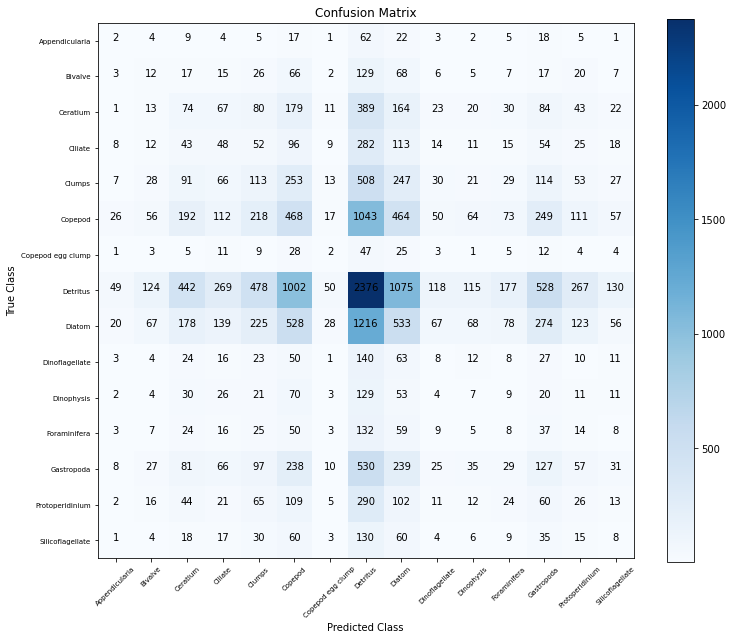

In [17]:
from confusion_matrix import plot_confusion_matrix


class_names = [
    "Appendicularia",
    "Bivalve",
    "Ceratium",
    "Ciliate",
    "Clumps",
    "Copepod",
    "Copepod egg clump",
    "Detritus",
    "Diatom",
    "Dinoflagellate",
    "Dinophysis",
    "Foraminifera",
    "Gastropoda",
    "Protoperidinium",
    "Silicoflagellate"
]
plot_confusion_matrix(matrix, class_names=class_names)



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(validation_dataset.classes, processed_validation_predictions)

0.16057347670250896

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)